In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn import linear_model
%matplotlib inline

# Delos Data Test

In this notebook ill be working on delos data test to try to explain how parameters (TAN ppm, Phosphate ppm, Phytoplankton density) changes over time.

There will be two parts in this notebook :
1. Quick look and Data Preparation.
    
2. Exploratory Data Analysis

# Quick look and Data Preparation

In [2]:
df = pd.read_csv('delos.csv', thousands=',')
df.head()

,Days of production,Pond Identifier,Temperature in the Morning,Temperature n the Afternoon,Temperature in the Evening,Feed per day (kg of shrimp feed),TAN ppm,Phosphate ppm,Phytoplankton cells/ml
0,1,A1,29,30,29,3.5,NaN,NaN,NaN
1,2,A1,30,32,29,3.5,NaN,NaN,NaN
2,3,A1,29,33,31,4,0.606,0.036,3000.0
3,4,A1,29,32,31,4,NaN,NaN,NaN
4,5,A1,30,30,28,4.5,NaN,NaN,NaN


Renaming Columns name so it is easier to work with.

In [3]:
df.rename(columns = {'Days of production' : 'Days of Production',
                    'Pond Identifier' : 'Pond ID',
                    'Temperature in the Morning' : 'Morning Temp',
                    'Temperature n the Afternoon' : 'Afternoon Temp',
                    'Temperature in the Evening' : 'Evening Temp',
                    'Feed per day (kg of shrimp feed)' : 'Feed/Day in Kg'}, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Days of Production      889 non-null    int64  
 1   Pond ID                 889 non-null    object 
 2   Morning Temp            889 non-null    int64  
 3   Afternoon Temp          889 non-null    object 
 4   Evening Temp            889 non-null    object 
 5   Feed/Day in Kg          889 non-null    object 
 6   TAN ppm                 248 non-null    float64
 7   Phosphate ppm           248 non-null    float64
 8   Phytoplankton cells/ml  248 non-null    float64
dtypes: float64(3), int64(2), object(4)
memory usage: 62.6+ KB


Assigning appropriate data type to each columns.

In [5]:
def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

In [6]:
df2 = df.copy()
df2 = df2[df2.applymap(isnumber)]
df2 = df2.applymap(float)
df2['Pond ID'] = df['Pond ID']
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Days of Production      889 non-null    float64
 1   Pond ID                 889 non-null    object 
 2   Morning Temp            889 non-null    float64
 3   Afternoon Temp          886 non-null    float64
 4   Evening Temp            886 non-null    float64
 5   Feed/Day in Kg          804 non-null    float64
 6   TAN ppm                 248 non-null    float64
 7   Phosphate ppm           248 non-null    float64
 8   Phytoplankton cells/ml  248 non-null    float64
dtypes: float64(8), object(1)
memory usage: 62.6+ KB


In [7]:
df2[df2['Afternoon Temp'].isnull()]

,Days of Production,Pond ID,Morning Temp,Afternoon Temp,Evening Temp,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml
76,77.0,A1,27.0,NaN,NaN,NaN,NaN,NaN,NaN
247,77.0,A3,28.0,NaN,NaN,5.0,NaN,NaN,NaN
700,77.0,A8,27.0,NaN,NaN,NaN,NaN,NaN,NaN


There are few missing data on 'Afternoon Temp' and 'Evening Temp' and quite a lot on 'Feed/Day in Kg'

First, i will be imputing the missing data on Temperature columns, and i will be imputing the data with the average temperature changes through out the day, to do that, ill be creating new column representing changes between each measurement, Morning to Afternoon (Temp Change to Afternoon) and Afternoon to Evening (Temp Change to Evening) then find the average, sum the newly created value to previous temperature measurement (adding Temp Change to afternoon to Morning temp value, Temp Change to Evening to Afternoon temp value) to impute the missing temperature measurement.

Note : im rounding the average changes so the result follow suit to the rest of measurement.

In [8]:
df2['Days of Production'] = df2['Days of Production'].astype('int64')
df2['Morning Temp'] = df2['Morning Temp'].astype('int64')
df2['Temp Change to Afternoon'] = df2['Afternoon Temp'] - df2['Morning Temp']
df2['Temp Change to Evening'] = df2['Evening Temp'] - df2['Afternoon Temp']
df2.head()

,Days of Production,Pond ID,Morning Temp,Afternoon Temp,Evening Temp,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml,Temp Change to Afternoon,Temp Change to Evening
0,1,A1,29,30.0,29.0,3.5,NaN,NaN,NaN,1.0,-1.0
1,2,A1,30,32.0,29.0,3.5,NaN,NaN,NaN,2.0,-3.0
2,3,A1,29,33.0,31.0,4.0,0.606,0.036,3000.0,4.0,-2.0
3,4,A1,29,32.0,31.0,4.0,NaN,NaN,NaN,3.0,-1.0
4,5,A1,30,30.0,28.0,4.5,NaN,NaN,NaN,0.0,-2.0


In [9]:
df2['Temp Change to Afternoon'].mean(skipna = True)

1.744920993227991

In [10]:
df2[df2['Days of Production'] == 77]

,Days of Production,Pond ID,Morning Temp,Afternoon Temp,Evening Temp,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml,Temp Change to Afternoon,Temp Change to Evening
76,77,A1,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,77,A2,28,29.0,29.0,5.0,NaN,NaN,NaN,1.0,0.0
247,77,A3,28,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
324,77,A4,27,29.0,29.0,5.0,NaN,NaN,NaN,2.0,0.0
418,77,A5,28,29.0,29.0,5.0,NaN,NaN,NaN,1.0,0.0
512,77,A6,27,29.0,29.0,5.0,NaN,NaN,NaN,2.0,0.0
606,77,A7,27,29.0,29.0,5.0,NaN,NaN,NaN,2.0,0.0
700,77,A8,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,77,A9,28,29.0,29.0,5.0,NaN,NaN,NaN,1.0,0.0
871,77,AA10,27,29.0,29.0,5.0,NaN,NaN,NaN,2.0,0.0


In [11]:
avg2728 = df2[df2['Morning Temp'].isin([27, 28])]
avg2728['Temp Change to Afternoon'].mean(skipna=True)

1.7420382165605095

In [12]:
noon_offset = round(df2['Temp Change to Afternoon'].mean(skipna = True))
df2['Afternoon Temp'].fillna(value = df2['Morning Temp'] + noon_offset, axis = 0, inplace = True)
eve_offset = round(df2['Temp Change to Evening'].mean(skipna = True))
df2['Evening Temp'].fillna(value = df2['Afternoon Temp'] + eve_offset, axis = 0, inplace = True)
df2.drop(['Temp Change to Afternoon', 'Temp Change to Evening'], axis = 1, inplace = True)
df2['Afternoon Temp'] = df2['Afternoon Temp'].astype('int64')
df2['Evening Temp'] = df2['Evening Temp'].astype('int64')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Days of Production      889 non-null    int64  
 1   Pond ID                 889 non-null    object 
 2   Morning Temp            889 non-null    int64  
 3   Afternoon Temp          889 non-null    int64  
 4   Evening Temp            889 non-null    int64  
 5   Feed/Day in Kg          804 non-null    float64
 6   TAN ppm                 248 non-null    float64
 7   Phosphate ppm           248 non-null    float64
 8   Phytoplankton cells/ml  248 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 62.6+ KB


In [13]:
df2[df2['Days of Production'] == 77]

,Days of Production,Pond ID,Morning Temp,Afternoon Temp,Evening Temp,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml
76,77,A1,27,29,28,NaN,NaN,NaN,NaN
153,77,A2,28,29,29,5.0,NaN,NaN,NaN
247,77,A3,28,30,29,5.0,NaN,NaN,NaN
324,77,A4,27,29,29,5.0,NaN,NaN,NaN
418,77,A5,28,29,29,5.0,NaN,NaN,NaN
512,77,A6,27,29,29,5.0,NaN,NaN,NaN
606,77,A7,27,29,29,5.0,NaN,NaN,NaN
700,77,A8,27,29,28,NaN,NaN,NaN,NaN
777,77,A9,28,29,29,5.0,NaN,NaN,NaN
871,77,AA10,27,29,29,5.0,NaN,NaN,NaN


Now that Temperature are fully imputed, we move to imputing 'Feed/Day in Kg'.
Explained in definitions, the amount of feed are affected by :
1. Feeding behaviour, which are not represented in the data
2. Observed growth, i assumed tied to days of production
3. Water conditions, which are not clear to me if its only temperature or there are other factors, also not clear if the temperature data is water temperature or not.

With the limited information given, ill be imputing it using regression estimation based on 'Days of Production' and average temperature that day.
assuming the temperature represented in the data affect the amount of feed.

reason why im using average daily temperature is to avoid multicolinearity if using each temp measurement and because the amount of feed represented are accumulation through out the day. (this is my assumption, i dont think the shrimp feed are all given in one feeding session, if so, then it is more appropriate to use related temperature measurement)

note : it will be nice change if the feed amount represented as each feeding session instead of sum of daily amount.

In [14]:
df2['Temp Avg'] = round(df2.iloc[:,2:5].sum(axis=1) / 3)
df2.head()

,Days of Production,Pond ID,Morning Temp,Afternoon Temp,Evening Temp,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml,Temp Avg
0,1,A1,29,30,29,3.5,NaN,NaN,NaN,29.0
1,2,A1,30,32,29,3.5,NaN,NaN,NaN,30.0
2,3,A1,29,33,31,4.0,0.606,0.036,3000.0,31.0
3,4,A1,29,32,31,4.0,NaN,NaN,NaN,31.0
4,5,A1,30,30,28,4.5,NaN,NaN,NaN,29.0


In [15]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
testdf = df2[df2['Feed/Day in Kg'].isnull()==True]
traindf = df2[df2['Feed/Day in Kg'].isnull()==False]
y = traindf['Feed/Day in Kg']
traindf.drop(['Feed/Day in Kg', 'TAN ppm', 'Phosphate ppm', 'Phytoplankton cells/ml', 'Pond ID', 
              'Morning Temp', 'Afternoon Temp', 'Evening Temp'],axis=1,inplace=True)
testdf.drop(['TAN ppm', 'Phosphate ppm', 'Phytoplankton cells/ml', 'Pond ID', 
              'Morning Temp', 'Afternoon Temp', 'Evening Temp'],axis=1,inplace=True)
lr.fit(traindf,y)
testdf.drop('Feed/Day in Kg',axis=1,inplace=True)
pred = lr.predict(testdf)
testdf['Feed/Day in Kg']= pred

C:\Users\fadhl\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\fadhl\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\fadhl\AppData\Local\Temp/ipykernel_8348/1843180322.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [16]:
testdf.head()

,Days of Production,Temp Avg,Feed/Day in Kg
31,32,30.0,20.876204
41,42,31.0,27.537404
42,43,30.0,25.744188
50,51,30.0,29.284540
62,63,29.0,32.359308


Rounding the value to nearest .5 value to follow existing measurement.

In [17]:
roundedfeed = round((testdf['Feed/Day in Kg']*2))/2

In [18]:
testdf['Feed/Day in Kg'] = roundedfeed

C:\Users\fadhl\AppData\Local\Temp/ipykernel_8348/1861053242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['Feed/Day in Kg'] = roundedfeed


In [19]:
traindf['Feed/Day in Kg'] = y

C:\Users\fadhl\AppData\Local\Temp/ipykernel_8348/1717638613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindf['Feed/Day in Kg'] = y


In [20]:
traindf.head()

,Days of Production,Temp Avg,Feed/Day in Kg
0,1,29.0,3.5
1,2,30.0,3.5
2,3,31.0,4.0
3,4,31.0,4.0
4,5,29.0,4.5


In [21]:
testdf.head()

,Days of Production,Temp Avg,Feed/Day in Kg
31,32,30.0,21.0
41,42,31.0,27.5
42,43,30.0,25.5
50,51,30.0,29.5
62,63,29.0,32.5


In [22]:
df3 = traindf.append(testdf, ignore_index=False)
df3.tail()

,Days of Production,Temp Avg,Feed/Day in Kg
859,65,30.0,35.5
861,67,30.0,36.5
862,68,29.0,34.5
866,72,29.0,36.5
880,86,30.0,45.0


In [23]:
df3.sort_index(inplace = True)
df4 = pd.merge(df3, df2[['Morning Temp', 'Afternoon Temp', 'Evening Temp', 'Pond ID', 
                         'TAN ppm', 'Phosphate ppm', 'Phytoplankton cells/ml']], left_index=True, right_index=True, copy=False)
df4.columns

Index(['Days of Production', 'Temp Avg', 'Feed/Day in Kg', 'Morning Temp',
       'Afternoon Temp', 'Evening Temp', 'Pond ID', 'TAN ppm', 'Phosphate ppm',
       'Phytoplankton cells/ml'],
      dtype='object')

In [24]:
df4 = df4.reindex(columns = ['Days of Production', 'Pond ID', 'Temp Avg', 'Morning Temp', 'Afternoon Temp', 'Evening Temp',
       'Feed/Day in Kg', 'TAN ppm', 'Phosphate ppm', 'Phytoplankton cells/ml'])

In [25]:
checknull = df4[df4['TAN ppm'].isnull()]
checknull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 0 to 888
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Days of Production      641 non-null    int64  
 1   Pond ID                 641 non-null    object 
 2   Temp Avg                641 non-null    float64
 3   Morning Temp            641 non-null    int64  
 4   Afternoon Temp          641 non-null    int64  
 5   Evening Temp            641 non-null    int64  
 6   Feed/Day in Kg          641 non-null    float64
 7   TAN ppm                 0 non-null      float64
 8   Phosphate ppm           0 non-null      float64
 9   Phytoplankton cells/ml  0 non-null      float64
dtypes: float64(5), int64(4), object(1)
memory usage: 55.1+ KB


In [26]:
checknull['Days of Production'].unique()

array([ 1,  2,  4,  5,  7,  8,  9, 11, 12, 14, 15, 16, 18, 19, 21, 22, 23,
       25, 26, 28, 29, 30, 32, 33, 35, 36, 37, 39, 40, 42, 43, 44, 46, 47,
       49, 50, 51, 53, 54, 56, 57, 58, 60, 61, 63, 64, 65, 67, 68, 70, 71,
       72, 74, 75, 77, 78, 79, 81, 82, 84, 85, 86, 88, 89, 91, 92, 93, 94],
      dtype=int64)

In [27]:
checknotnull = df4[df4['TAN ppm'].notnull()]
checknotnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248 entries, 2 to 884
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Days of Production      248 non-null    int64  
 1   Pond ID                 248 non-null    object 
 2   Temp Avg                248 non-null    float64
 3   Morning Temp            248 non-null    int64  
 4   Afternoon Temp          248 non-null    int64  
 5   Evening Temp            248 non-null    int64  
 6   Feed/Day in Kg          248 non-null    float64
 7   TAN ppm                 248 non-null    float64
 8   Phosphate ppm           248 non-null    float64
 9   Phytoplankton cells/ml  248 non-null    float64
dtypes: float64(5), int64(4), object(1)
memory usage: 21.3+ KB


In [28]:
checknotnull['Days of Production'].unique()

array([ 3,  6, 10, 13, 17, 20, 24, 27, 31, 34, 38, 41, 45, 48, 52, 55, 59,
       62, 66, 69, 73, 76, 80, 83, 87, 90], dtype=int64)

After inspecting the data further, it seems there are repeating pattern on when the parameters measurement are taken, looks like parameters are taken on 4th and 3rd day alternately (possibly monday and friday). (Excluding the first measurement if the recording start at day 1 instead of 0).

With that, ill be continuing to the analysis only using data that have parameters.

Note : by the end of this notebook, i modeled the data where i assume each parameters measurement are affected by the previous day, the data is summarized between each measurement taken, replacing 'Day of Production' to 'Measurement Order'. (ex : because the first measurement taken at day 3, data from day 1 through day 3 are summarized)
reason why i dont continue the analysis using this, is because im not sure how should i summarized each variables. 

# Exploratory Data Analysis
After we done with the preparation, now we can start exploring the data, in this part, you will see variables in the data plotted againts the parameters to see if there are some kind relationships and hopefully to infere something out of it.

In [29]:
checknotnull.describe()

,Days of Production,Temp Avg,Morning Temp,Afternoon Temp,Evening Temp,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,44.637097,29.471774,28.741935,30.334677,29.528226,26.635081,0.735968,0.177581,9612.096774
std,25.461198,1.123547,0.959681,1.299676,1.049007,14.568729,0.505391,0.106387,4680.809175
min,3.000000,27.000000,27.000000,27.000000,27.000000,4.000000,0.113000,0.018000,2000.000000
25%,24.000000,29.000000,28.000000,30.000000,29.000000,19.000000,0.334500,0.107750,5500.000000
50%,45.000000,30.000000,29.000000,30.000000,30.000000,26.000000,0.619500,0.158500,10000.000000
75%,66.000000,30.000000,29.000000,31.000000,30.000000,34.000000,0.972250,0.226000,12500.000000
max,90.000000,31.000000,31.000000,33.000000,31.000000,64.000000,2.774000,0.581000,23500.000000


In [30]:
checknotnull['Temp Avg'].median(), checknotnull['Temp Avg'].mode()

(30.0,
 0    30.0
 dtype: float64)

## Days of Production

Plot below are the average amount of measurement on each 'Days of Production' and each 'Pond ID'

In [31]:
dayvsfeed = checknotnull.pivot('Days of Production', 'Pond ID', 'Feed/Day in Kg')
dayvstan = checknotnull.pivot('Days of Production', 'Pond ID', 'TAN ppm')
dayvsphos = checknotnull.pivot('Days of Production', 'Pond ID', 'Phosphate ppm')
dayvscell = checknotnull.pivot('Days of Production', 'Pond ID', 'Phytoplankton cells/ml')

### vs Feed/Day

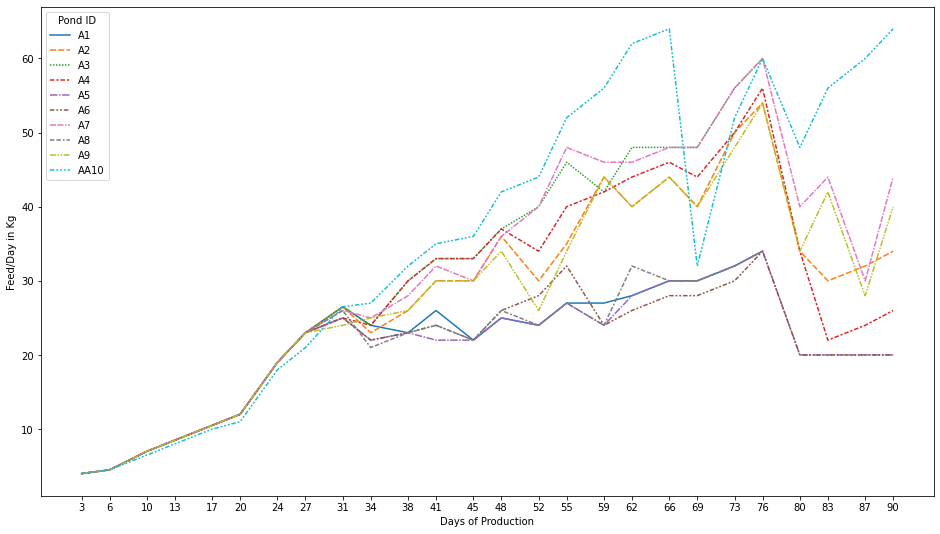

In [32]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.lineplot(data = dayvsfeed)
ax.set(xticks = dayvsfeed.index)
ax.set_ylabel("Feed/Day in Kg")
plt.show()

Plotting 'Feed/Day in Kg' over 'Days of Production' individually per Pond ID :
- Feeding pattern on all ponds seems to be generally the same until day 31.
- After day 31, while all the ponds feeding pattern still generally increases over time, the number and the amount of increase are more varied.
- The longer the production goes, seems the feeding pattern are more departed from its previous pattern.

aside from the stated explanation that days of production affect the amount of feed given, it seems there are other factors to each pond that also affecting amounnt of feed given.

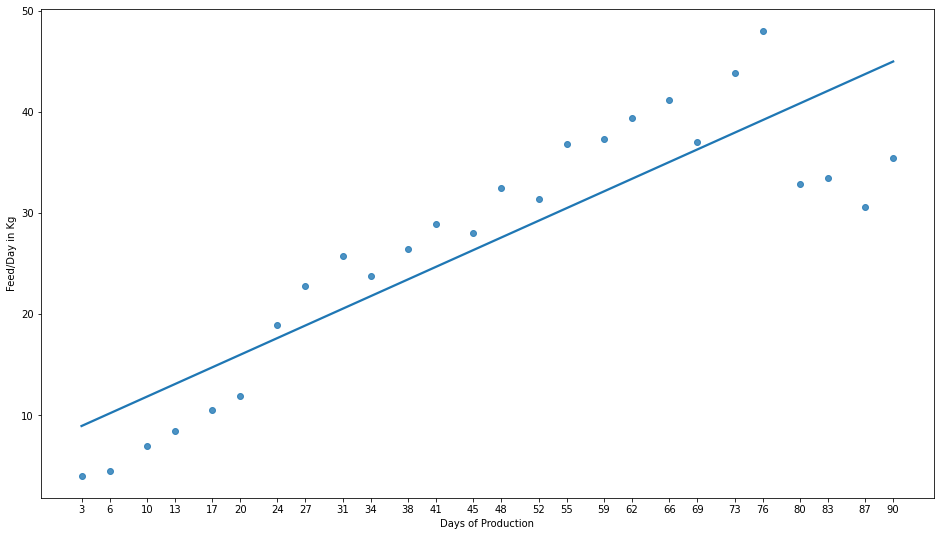

In [33]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=checknotnull.groupby(by='Days of Production', as_index=False).mean(), x='Days of Production', y='Feed/Day in Kg', ci=None)
ax.set(xticks = checknotnull.groupby(by='Days of Production').mean().index)
plt.show()

Above plot are the average of 'Feed/Day in Kg' across all ponds over 'Days of Production', as you can see, over time, the amount of feed also increases.

### vs TAN ppm

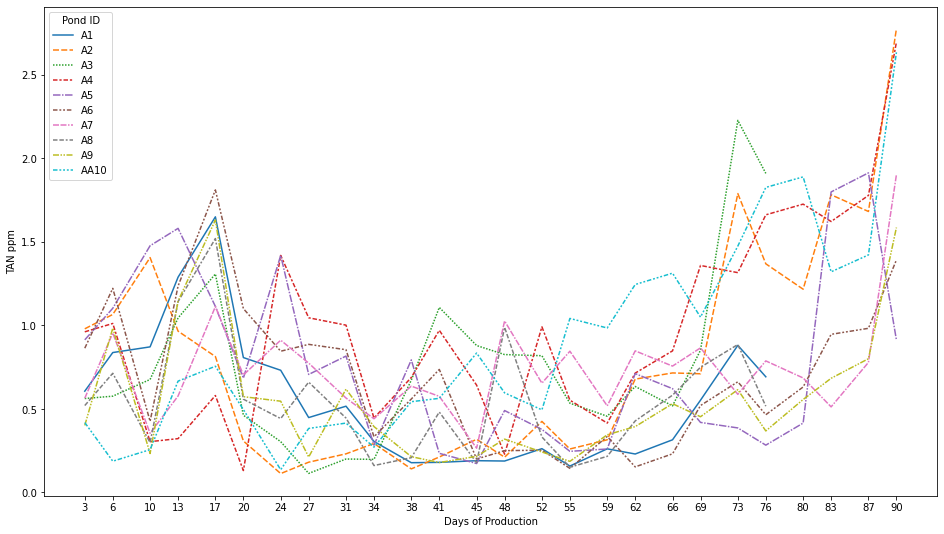

In [34]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.lineplot(data = dayvstan)
ax.set(xticks = dayvstan.index)
ax.set_ylabel("TAN ppm")
plt.show()

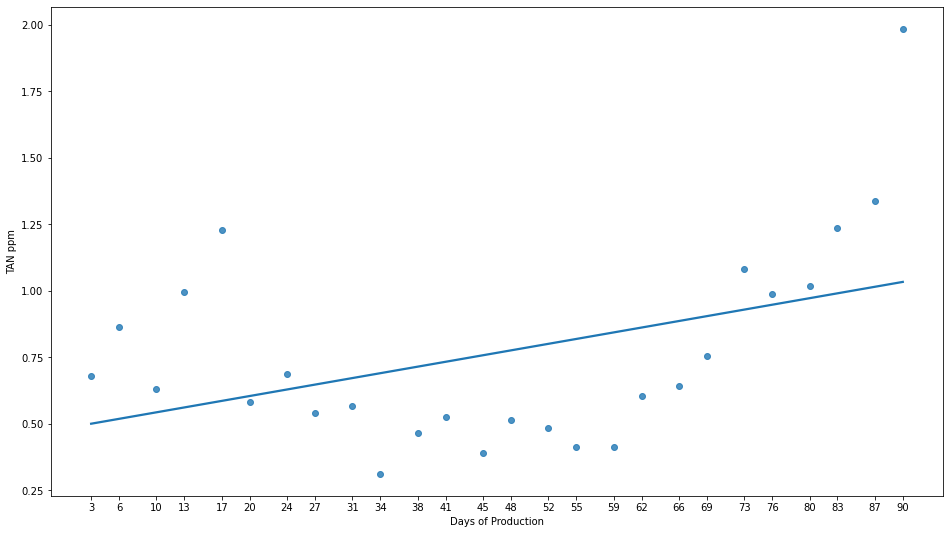

In [35]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=checknotnull.groupby(by='Days of Production', as_index=False).mean(), x='Days of Production', y='TAN ppm', ci=None)
ax.set(xticks = checknotnull.groupby(by='Days of Production').mean().index)
plt.show()

### vs Phosphate ppm

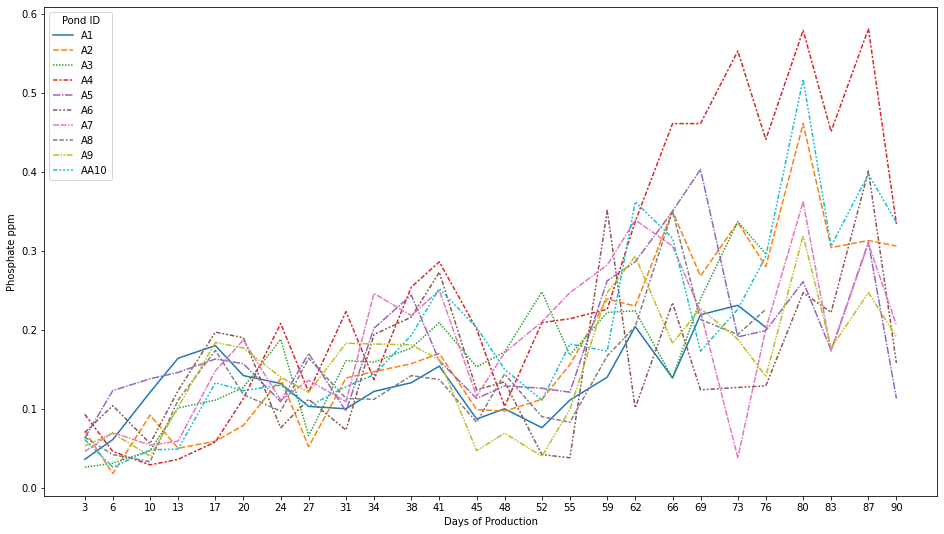

In [36]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.lineplot(data = dayvsphos)
ax.set(xticks = dayvsphos.index)
ax.set_ylabel("Phosphate ppm")
plt.show()

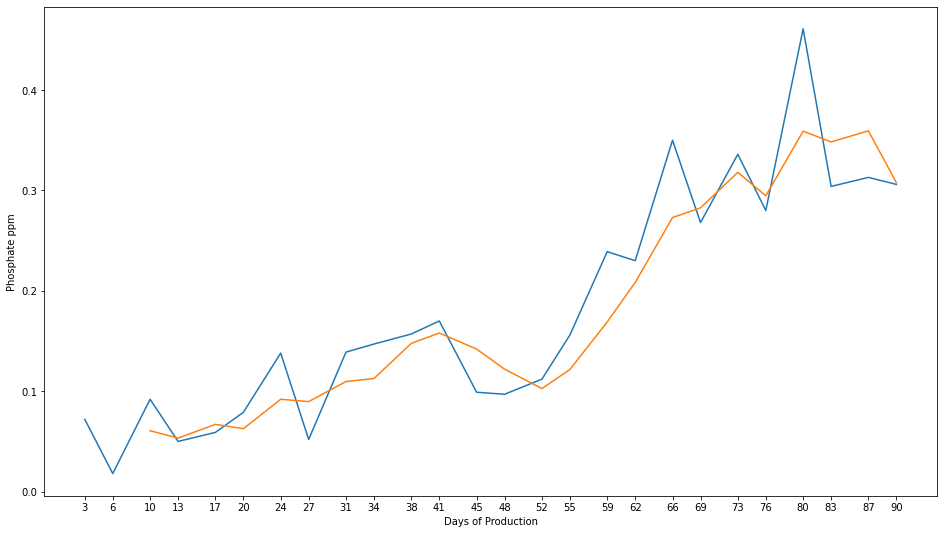

In [37]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data = dayvsphos['A2'])
sns.lineplot(x=dayvsphos.index, y=dayvsphos['A2'].rolling(3).mean())
ax.set(xticks = dayvsphos.index)
ax.set_ylabel("Phosphate ppm")
plt.show()

All ponds seems to follow the general pattern that repeating ups and downs, but overall generally increases over time.
Same as before, seems there are specific factor to each ponds causing these ups and downs.

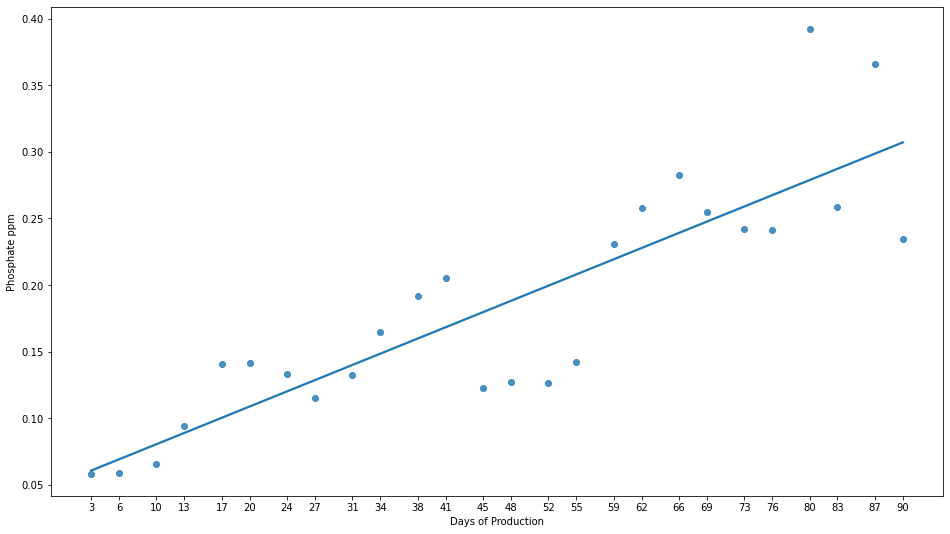

In [38]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=checknotnull.groupby(by='Days of Production', as_index=False).mean(), x='Days of Production', y='Phosphate ppm', ci=None)
ax.set(xticks = checknotnull.groupby(by='Days of Production').mean().index)
plt.show()

### vs Phytoplankton cells/ml

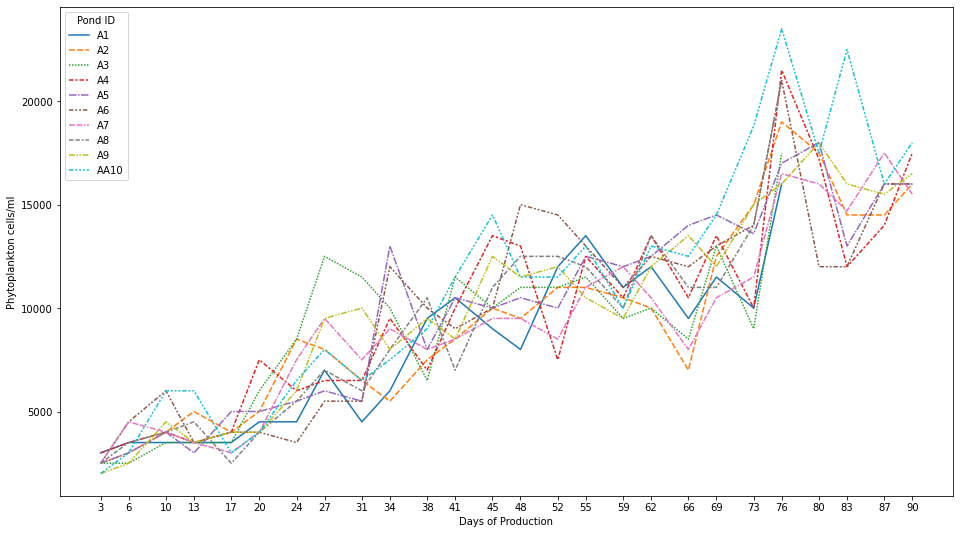

In [39]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.lineplot(data = dayvscell)
ax.set(xticks = dayvscell.index)
ax.set_ylabel("Phytoplankton cells/ml")
plt.show()

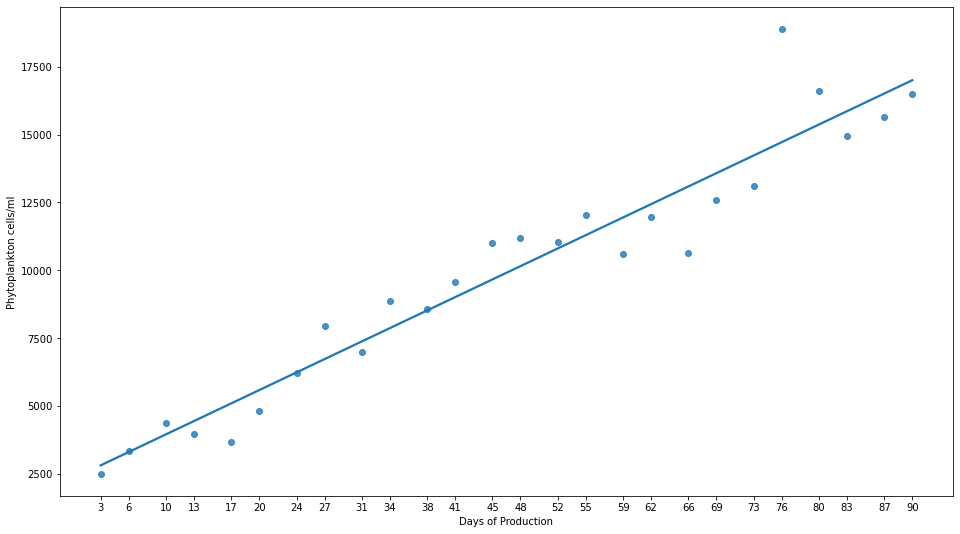

In [40]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=checknotnull.groupby(by='Days of Production', as_index=False).mean(), x='Days of Production', y='Phytoplankton cells/ml', ci=None)
ax.set(xticks = checknotnull.groupby(by='Days of Production').mean().index)
plt.show()

Same cases as Phosphate ppm but much more consistent.

Days of Production influences :
1. Amount of feed given
2. Phospate ppm
3. Pythoplankton density

# Daily Temperature Average

Plot below are the average amount of measurement per Average temperature on each Pond ID

In [41]:
gbtempid = checknotnull.groupby(by=['Pond ID', 'Temp Avg'], as_index=False).mean()

In [42]:
tempvsfeed = gbtempid.pivot('Temp Avg', 'Pond ID', 'Feed/Day in Kg')
tempvstan = gbtempid.pivot('Temp Avg', 'Pond ID', 'TAN ppm')
tempvsphos = gbtempid.pivot('Temp Avg', 'Pond ID', 'Phosphate ppm')
tempvscell = gbtempid.pivot('Temp Avg', 'Pond ID', 'Phytoplankton cells/ml')

### vs Feed/Day in Kg

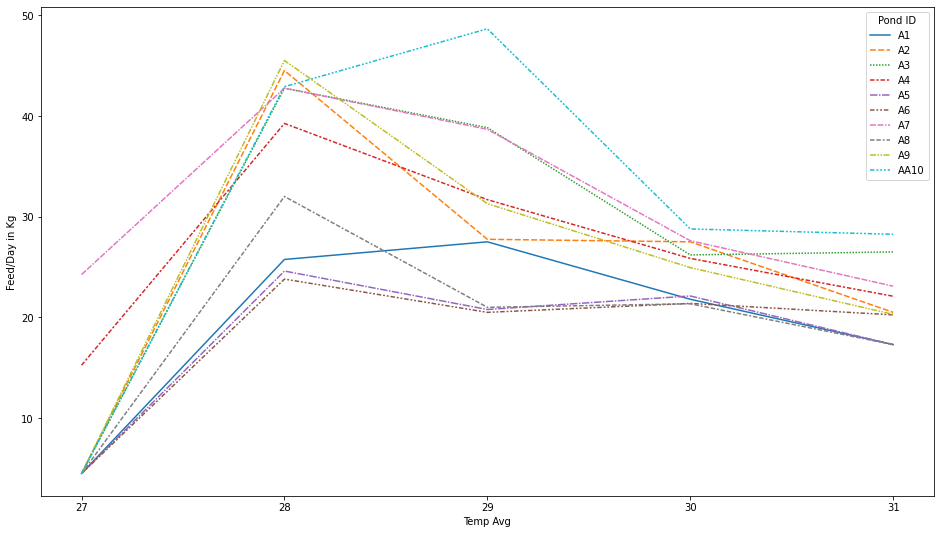

In [43]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.lineplot(data = tempvsfeed)
ax.set(xticks = tempvsfeed.index)
ax.set_ylabel("Feed/Day in Kg")
plt.show()

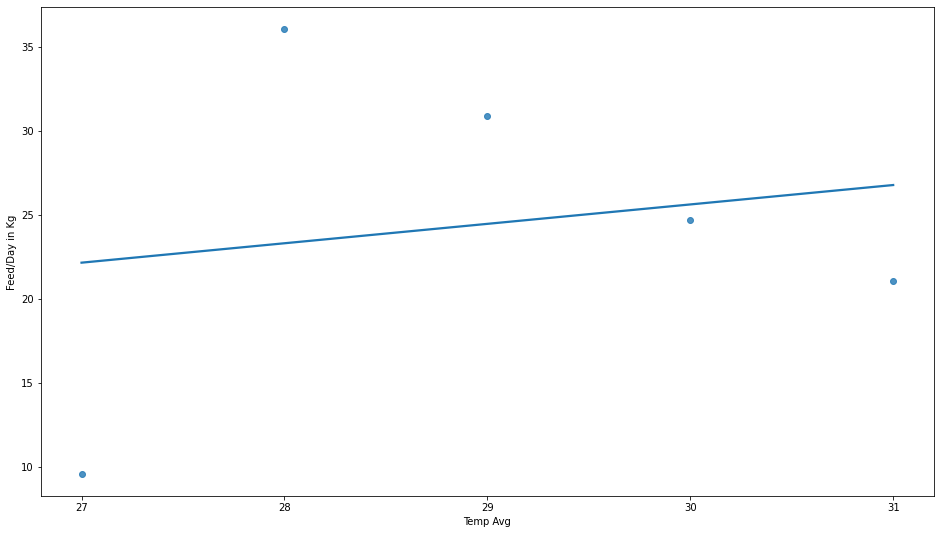

In [44]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=checknotnull.groupby(by='Temp Avg', as_index=False).mean(), x='Temp Avg', y='Feed/Day in Kg', ci=None)
ax.set(xticks = checknotnull.groupby(by='Temp Avg').mean().index)
plt.show()

### vs TAN ppm

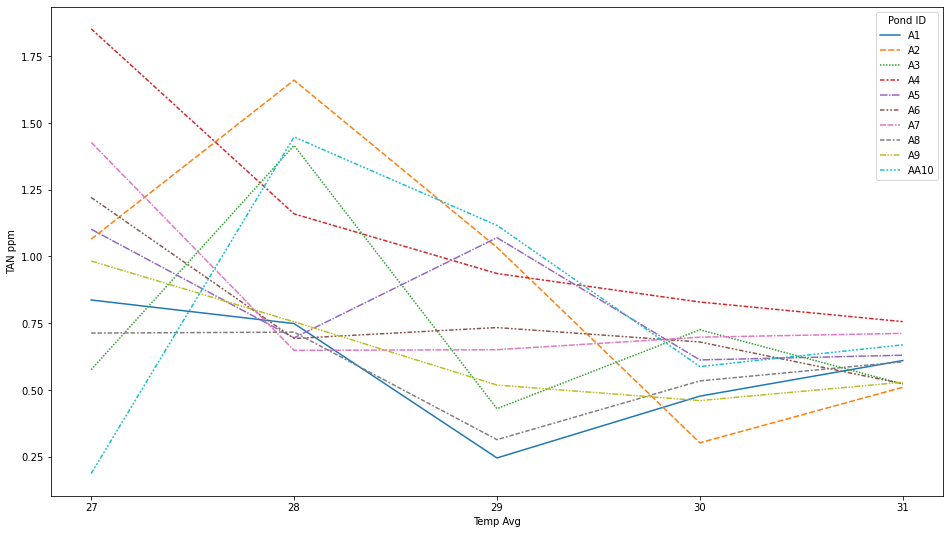

In [45]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.lineplot(data = tempvstan)
ax.set(xticks = tempvstan.index)
ax.set_ylabel("TAN ppm")
plt.show()

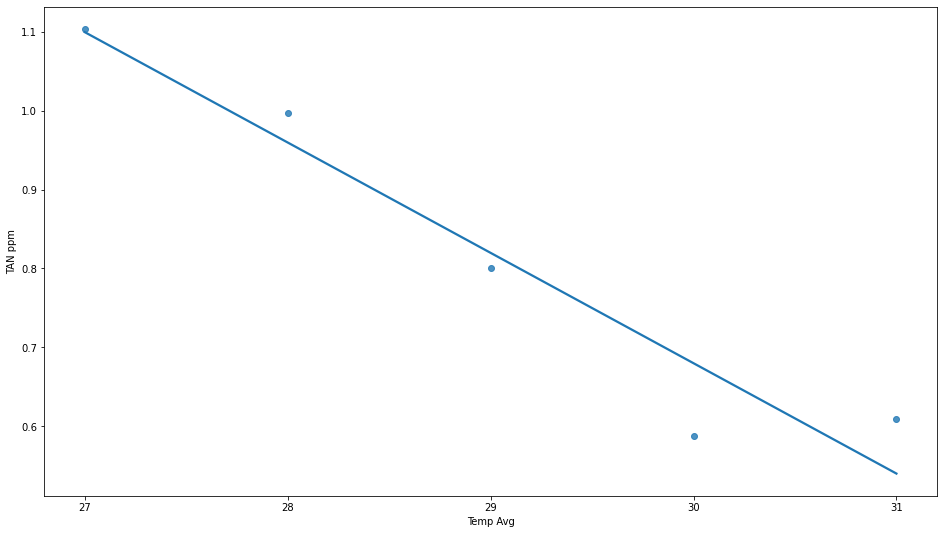

In [46]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=checknotnull.groupby(by='Temp Avg', as_index=False).mean(), x='Temp Avg', y='TAN ppm', ci=None)
ax.set(xticks = checknotnull.groupby(by='Temp Avg').mean().index)
plt.show()

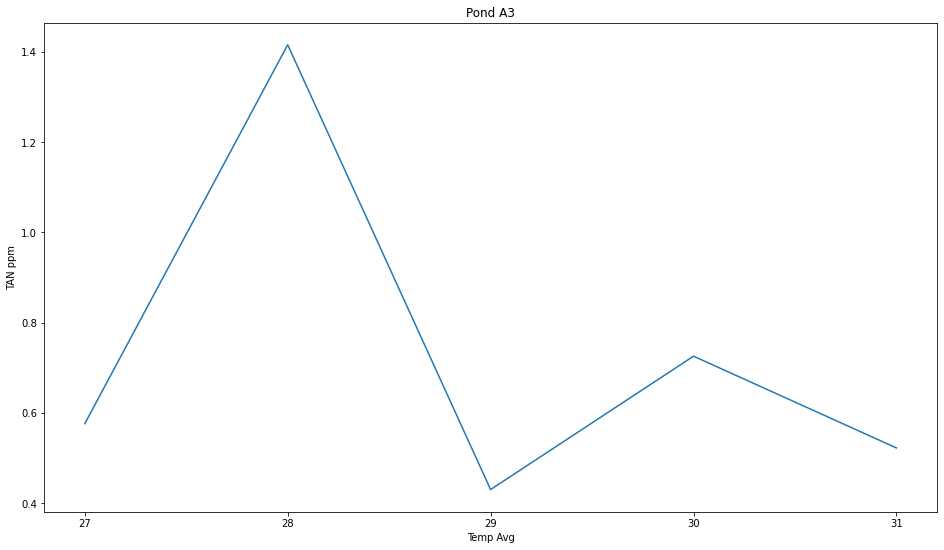

In [47]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data = tempvstan['A3']).set_title('Pond A3')
ax.set(xticks = tempvstan.index)
ax.set_ylabel("TAN ppm")
plt.show()

While on average we can see that the the amount of TAN ppm decreases as the temperature increases, looking at the Pond individually, some ponds does not behave closely to other ponds or the average behavior.

### vs Phosphate ppm

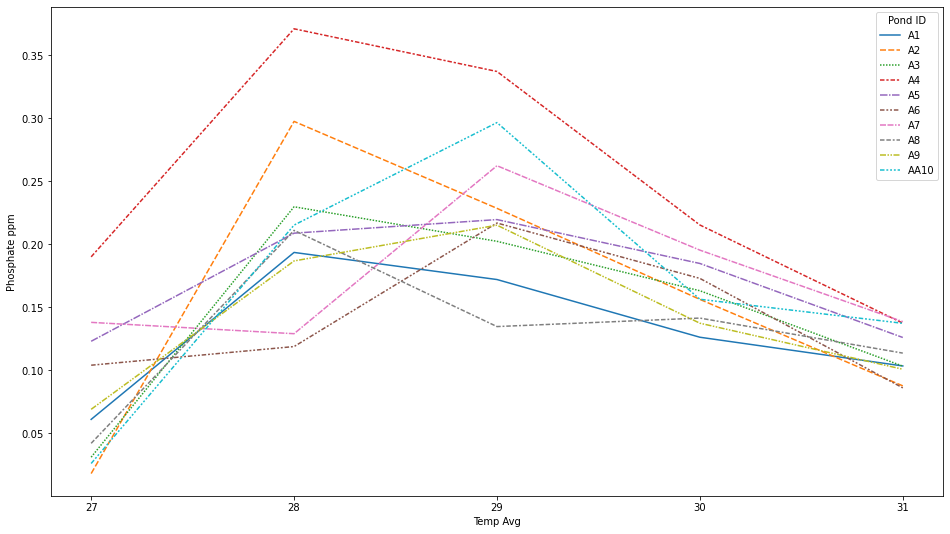

In [48]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.lineplot(data = tempvsphos)
ax.set(xticks = tempvsphos.index)
ax.set_ylabel("Phosphate ppm")
plt.show()

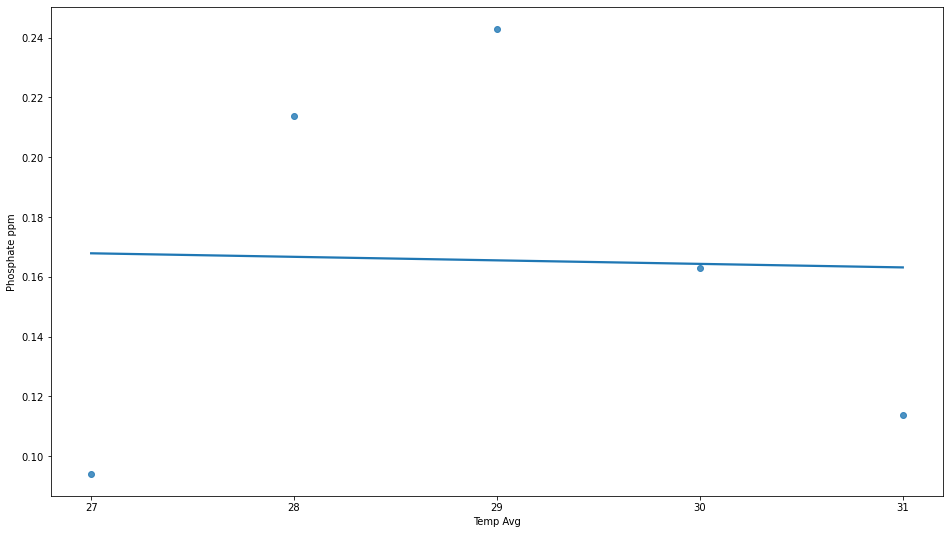

In [49]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=checknotnull.groupby(by='Temp Avg', as_index=False).mean(), x='Temp Avg', y='Phosphate ppm', ci=None)
ax.set(xticks = checknotnull.groupby(by='Temp Avg').mean().index)
plt.show()

### vs Phytoplankton cells/ml

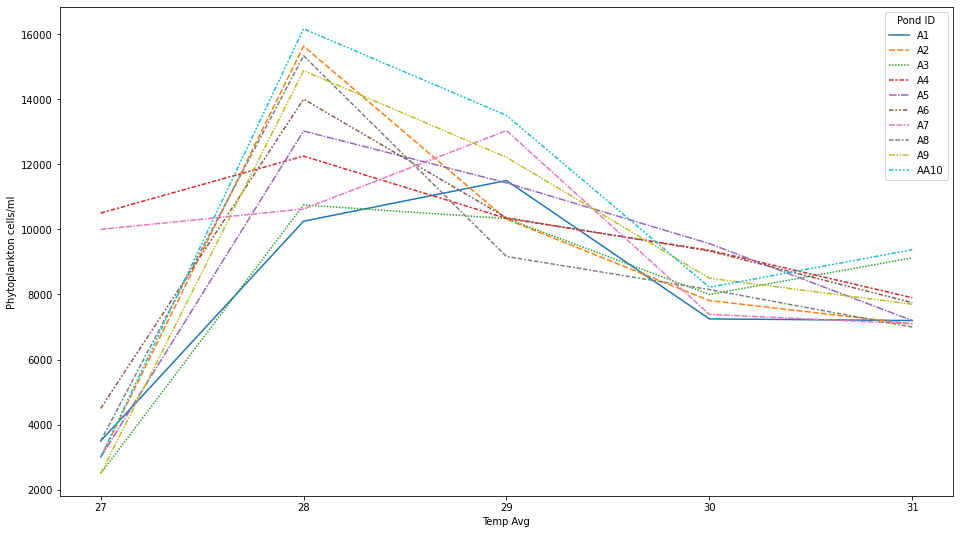

In [50]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.lineplot(data = tempvscell)
ax.set(xticks = tempvscell.index)
ax.set_ylabel("Phytoplankton cells/ml")
plt.show()

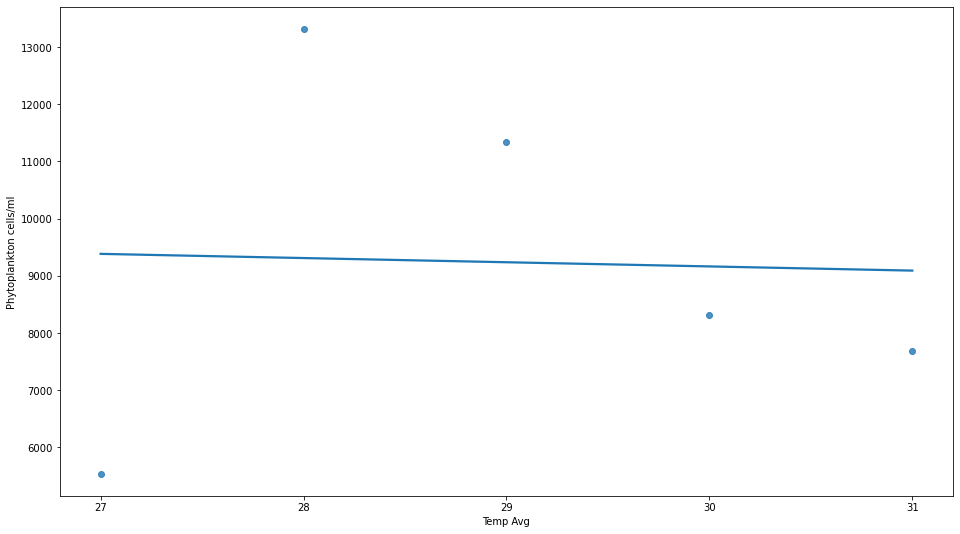

In [51]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=checknotnull.groupby(by='Temp Avg', as_index=False).mean(), x='Temp Avg', y='Phytoplankton cells/ml', ci=None)
ax.set(xticks = checknotnull.groupby(by='Temp Avg').mean().index)
plt.show()

Daily Temperature Average influences :
1. TAN (Total Ammonia Nitrate) ppm.

with that being said, based on the individual pond plot, there are few ponds that doesnt follow the pattern.
I assume there are properties/condition/treatment that are unique to each pond that also affect this measurement.

# Feed per Day

Plot below are the average amount of measurement on average Feed/Day per each Pond ID

In [52]:
gbfeedid = checknotnull.groupby(by=['Pond ID', 'Feed/Day in Kg'], as_index=False).mean()

In [53]:
feedvstan = gbfeedid.pivot('Feed/Day in Kg', 'Pond ID', 'TAN ppm')
feedvsphos = gbfeedid.pivot('Feed/Day in Kg', 'Pond ID', 'Phosphate ppm')
feedvscell = gbfeedid.pivot('Feed/Day in Kg', 'Pond ID', 'Phytoplankton cells/ml')

### vs TAN ppm

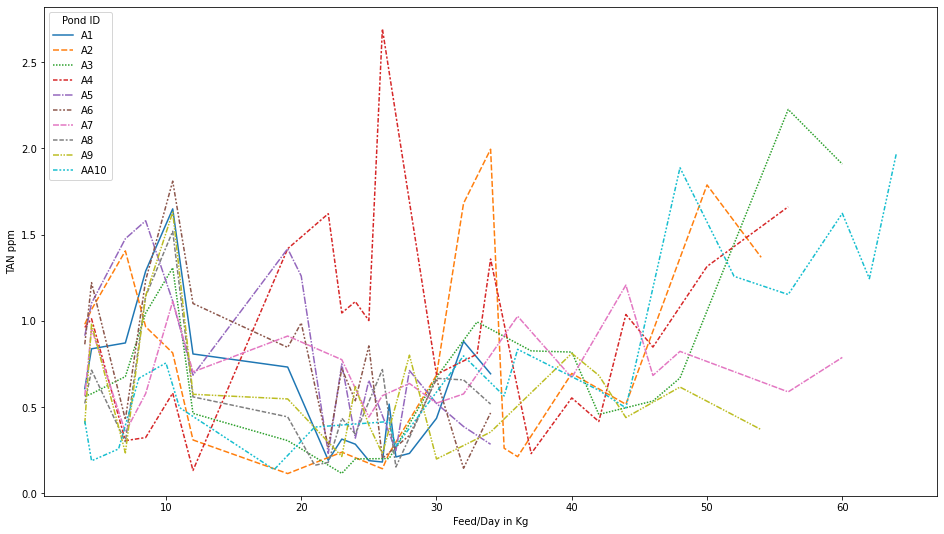

In [54]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.lineplot(data = feedvstan)
ax.set_ylabel("TAN ppm")
plt.show()

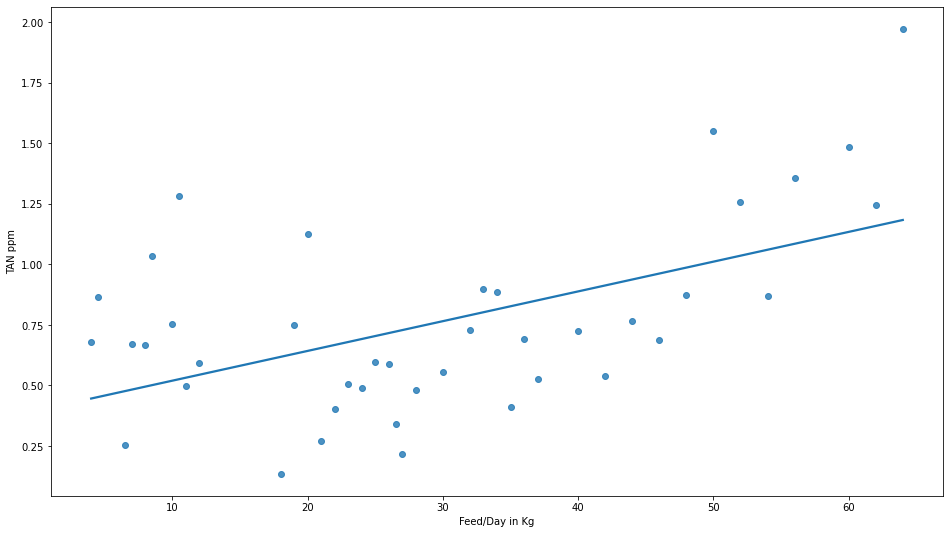

In [55]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=checknotnull.groupby(by='Feed/Day in Kg', as_index=False).mean(), x='Feed/Day in Kg', y='TAN ppm', ci=None)
plt.show()

### vs Phosphate ppm

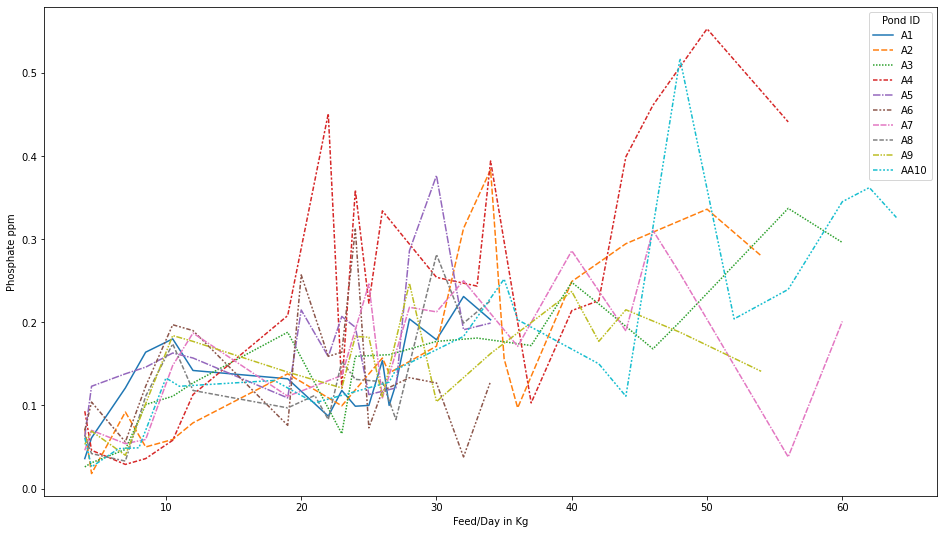

In [56]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.lineplot(data = feedvsphos)
ax.set_ylabel("Phosphate ppm")
plt.show()

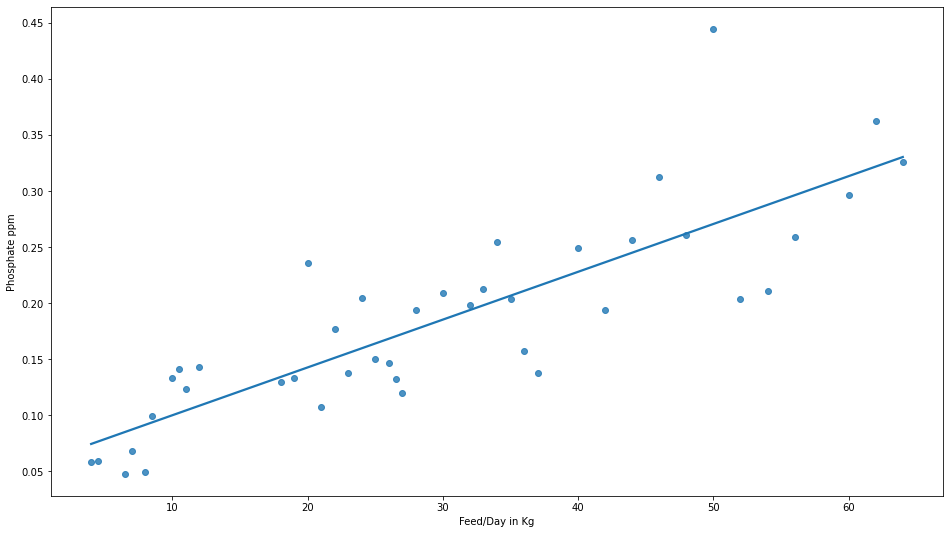

In [57]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=checknotnull.groupby(by='Feed/Day in Kg', as_index=False).mean(), x='Feed/Day in Kg', y='Phosphate ppm', ci=None)
plt.show()

aside from few outliers, generally, amount of phosphate ppm generally increases as feed amount increases.

### vs Phytoplankton cells/ml

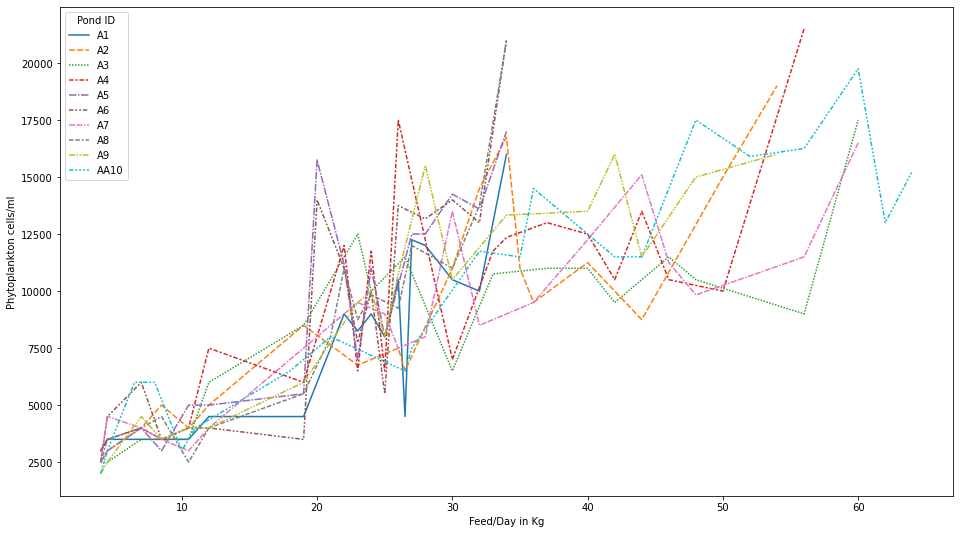

In [58]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.lineplot(data = feedvscell)
ax.set_ylabel("Phytoplankton cells/ml")
plt.show()

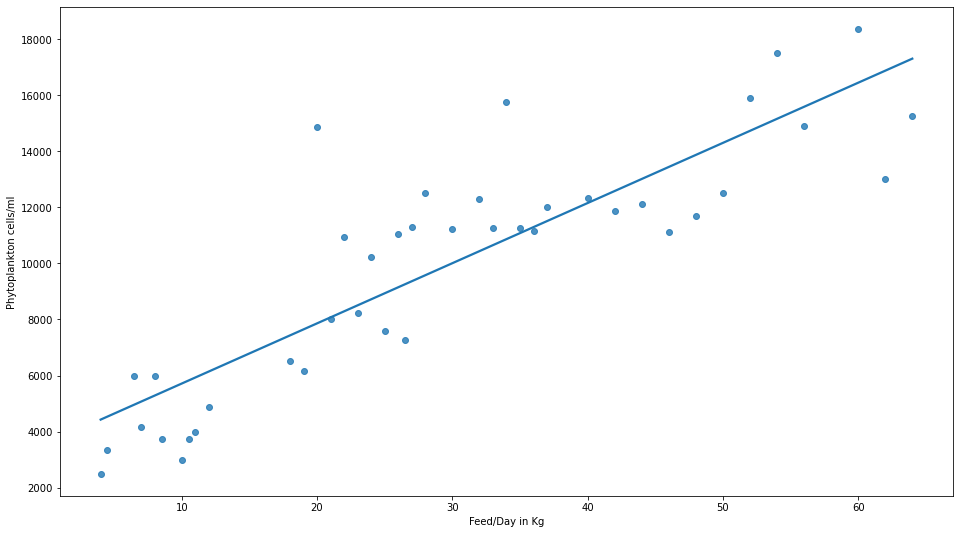

In [59]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=checknotnull.groupby(by='Feed/Day in Kg', as_index=False).mean(), x='Feed/Day in Kg', y='Phytoplankton cells/ml', ci=None)
plt.show()

Same case with Phosphate ppm, but if we refer back to 'Days of Production', 'Days of Production' also affects amount of feed and amount of Phytoplankton cells/ml, so because over the production days both amount of feed and amount of Phytoplankton cells, we cannot be sure that Feed amount causes amount of phytoplankton density.

Amount of Feed per Day influences :

1. Phosphate ppm
2. Phytoplankton cells/ml

# -----------------------

## Recap : Input

Days of Production influences :
1. 'Feed/Day in KG'
2. 'Phosphate ppm'
3. 'Phytoplankton cells/ml'

Daily Average Temperature influences :
1. 'TAN ppm'

Amount of Feed per day influences :
1. 'Phosphate ppm'
2. 'Phytoplankton cells/ml'

Regarding 'Phospate ppm' and 'Phytoplankton cells/ml', because Feed/Day increases as the production days goes, we cant be sure if the increase in Phosphate ppm and Phytoplankton cells/ml is caused due to either the production days or the feed amount or both.

# Daily Average Across All Ponds
Below value are day average across all ponds, to see if on average if each parameters related to each other or not.

In [60]:
days = checknotnull.groupby(by=['Days of Production'], as_index=False).mean()
days

,Days of Production,Temp Avg,Morning Temp,Afternoon Temp,Evening Temp,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml
0,3,31.000000,29.300000,32.1,31.000000,4.000000,0.678700,0.058400,2500.000000
1,6,27.000000,27.000000,27.0,27.000000,4.500000,0.864900,0.059000,3350.000000
2,10,28.300000,28.000000,29.0,28.300000,6.950000,0.629900,0.065800,4350.000000
3,13,29.600000,29.000000,30.5,29.100000,8.450000,0.996400,0.094100,3950.000000
4,17,30.700000,29.400000,32.0,30.700000,10.450000,1.228800,0.140700,3650.000000
5,20,30.000000,29.000000,31.0,30.000000,11.900000,0.582200,0.141300,4800.000000
6,24,30.000000,30.000000,30.0,30.000000,18.900000,0.686400,0.132900,6200.000000
7,27,31.000000,30.300000,32.0,30.800000,22.800000,0.540900,0.114800,7950.000000
8,31,29.200000,28.700000,29.8,29.200000,25.700000,0.566100,0.132600,7000.000000
9,34,30.000000,29.000000,31.4,29.800000,23.700000,0.312400,0.164400,8850.000000


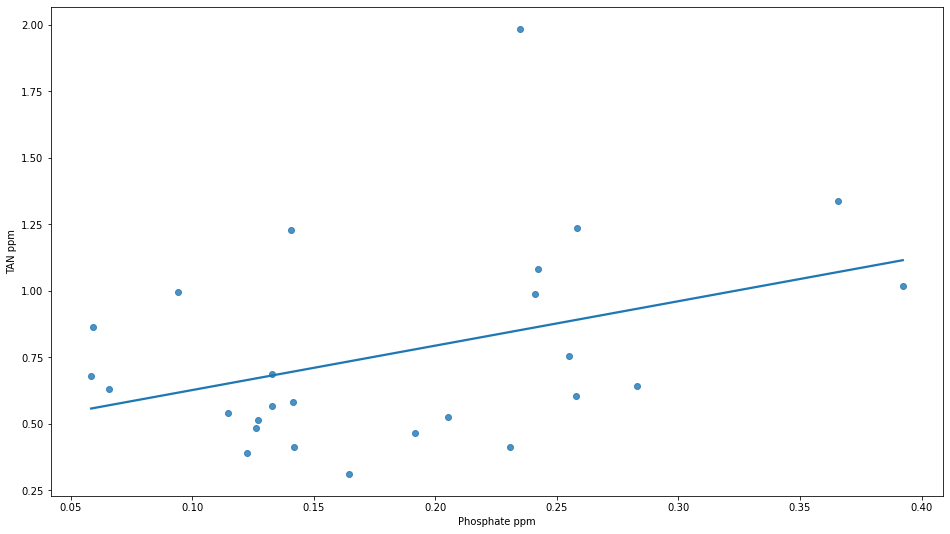

In [61]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=days, x='Phosphate ppm', y='TAN ppm', ci=None)
plt.show()

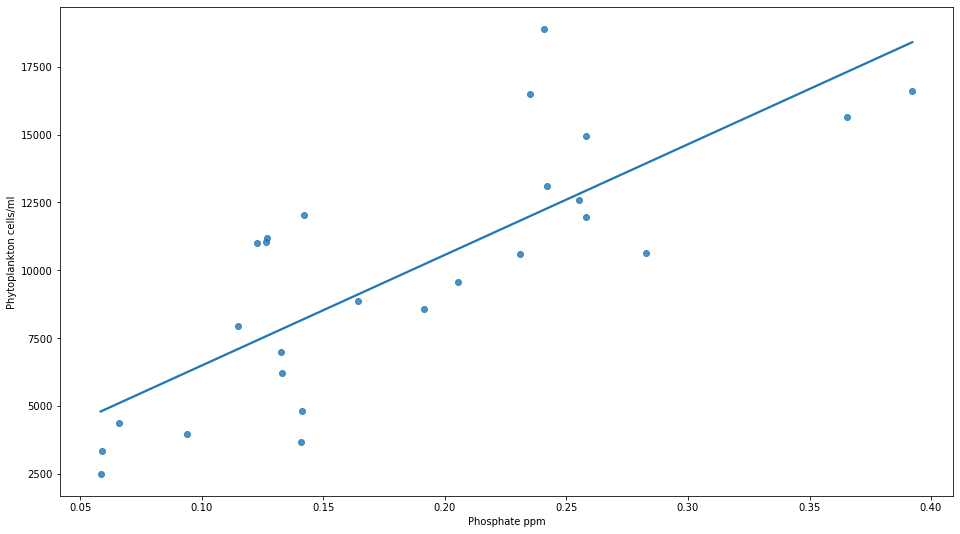

In [62]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=days, x='Phosphate ppm', y='Phytoplankton cells/ml', ci=None)
plt.show()

Even though the plot show that 'Phytoplankton cells/ml' increases as 'Phosphate ppm' increases, refering back to previous recap, both 'Phytoplankton cells/ml' and 'Phosphate ppm' are affected by 'Feed/Day in Kg' which generally increases over the production days.

unless there some test conducted that directly changes "Pythoplankton cells/ml" or "Phosphate ppm" without changing the amount of 'Feed/Day in Kg' i wouldnt say these two parameters are dependent on each other.

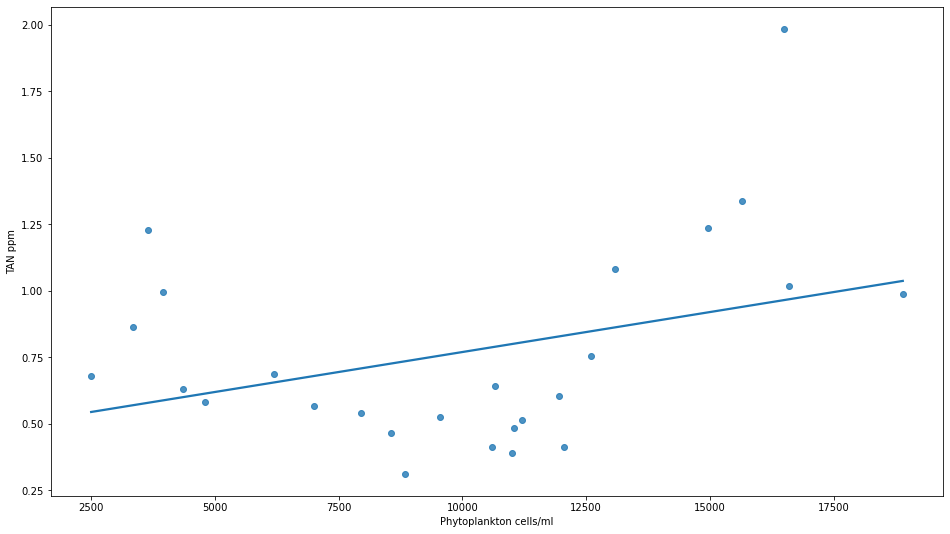

In [63]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.regplot(data=days, x='Phytoplankton cells/ml', y='TAN ppm', ci=None)
plt.show()

## Conclusion

After analyzing each parameters over input presented in this dataset, i conclude that :
1. On average, Feed/Day in KG increases over production days goes but not related to temperature
2. On average, Temperature does related to amount of 'TAN ppm', as the Temperature rises, 'TAN ppm' decreases
3. On average, 'Phosphate ppm' and 'Phytoplankton cells/ml' affected by either or both 'Days of Production' or 'Feed/Day in Kg'

Keep in mind that these are on average over all ponds, when compared to individual pond, there are few ponds that does not follow the average, with that, i infere that there are some data point related to each pond that also affect the parameters.

## =========================================================================
                                                
## =========================================================================

In [64]:
df4

,Days of Production,Pond ID,Temp Avg,Morning Temp,Afternoon Temp,Evening Temp,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml
0,1,A1,29.0,29,30,29,3.5,NaN,NaN,NaN
1,2,A1,30.0,30,32,29,3.5,NaN,NaN,NaN
2,3,A1,31.0,29,33,31,4.0,0.606,0.036,3000.0
3,4,A1,31.0,29,32,31,4.0,NaN,NaN,NaN
4,5,A1,29.0,30,30,28,4.5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
884,90,AA10,28.0,28,28,28,64.0,2.633,0.336,18000.0
885,91,AA10,28.0,27,29,29,64.0,NaN,NaN,NaN
886,92,AA10,29.0,28,29,29,64.0,NaN,NaN,NaN
887,93,AA10,28.0,28,28,28,64.0,NaN,NaN,NaN


In [65]:
checknotnull

,Days of Production,Pond ID,Temp Avg,Morning Temp,Afternoon Temp,Evening Temp,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml
2,3,A1,31.0,29,33,31,4.0,0.606,0.036,3000.0
5,6,A1,27.0,27,27,27,4.5,0.837,0.061,3500.0
9,10,A1,28.0,28,29,28,7.0,0.871,0.121,3500.0
12,13,A1,30.0,29,31,29,8.5,1.288,0.164,3500.0
16,17,A1,31.0,29,32,31,10.5,1.649,0.180,3500.0
...,...,...,...,...,...,...,...,...,...,...
870,76,AA10,28.0,28,29,28,60.0,1.825,0.293,23500.0
874,80,AA10,29.0,29,30,29,48.0,1.888,0.517,17500.0
877,83,AA10,29.0,28,30,29,56.0,1.320,0.306,22500.0
881,87,AA10,29.0,28,30,29,60.0,1.421,0.397,16000.0


In [66]:
checknotnull['Measurement Order'] = checknotnull.groupby(['Pond ID']).cumcount()+1

C:\Users\fadhl\AppData\Local\Temp/ipykernel_8348/3977013409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checknotnull['Measurement Order'] = checknotnull.groupby(['Pond ID']).cumcount()+1


In [67]:
checknotnull.head(23)

,Days of Production,Pond ID,Temp Avg,Morning Temp,Afternoon Temp,Evening Temp,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml,Measurement Order
2,3,A1,31.0,29,33,31,4.0,0.606,0.036,3000.0,1
5,6,A1,27.0,27,27,27,4.5,0.837,0.061,3500.0,2
9,10,A1,28.0,28,29,28,7.0,0.871,0.121,3500.0,3
12,13,A1,30.0,29,31,29,8.5,1.288,0.164,3500.0,4
16,17,A1,31.0,29,32,31,10.5,1.649,0.180,3500.0,5
19,20,A1,30.0,29,31,30,12.0,0.807,0.142,4500.0,6
23,24,A1,30.0,30,30,30,19.0,0.731,0.132,4500.0,7
26,27,A1,31.0,30,32,31,23.0,0.448,0.103,7000.0,8
30,31,A1,30.0,29,30,30,26.5,0.516,0.100,4500.0,9
33,34,A1,30.0,29,32,30,24.0,0.305,0.122,6000.0,10


In [68]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Days of Production      889 non-null    int64  
 1   Pond ID                 889 non-null    object 
 2   Morning Temp            889 non-null    int64  
 3   Afternoon Temp          889 non-null    int64  
 4   Evening Temp            889 non-null    int64  
 5   Feed/Day in Kg          804 non-null    float64
 6   TAN ppm                 248 non-null    float64
 7   Phosphate ppm           248 non-null    float64
 8   Phytoplankton cells/ml  248 non-null    float64
 9   Temp Avg                889 non-null    float64
dtypes: float64(5), int64(4), object(1)
memory usage: 69.6+ KB


In [69]:
model2=pd.merge(df4[['Pond ID', 'Morning Temp', 'Afternoon Temp', 'Evening Temp', 'Temp Avg', 'Feed/Day in Kg', 
                    'TAN ppm', 'Phosphate ppm', 'Phytoplankton cells/ml']],checknotnull['Measurement Order'], 
         left_index=True, right_index=True, copy=False, how='left')

model2

,Pond ID,Morning Temp,Afternoon Temp,Evening Temp,Temp Avg,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml,Measurement Order
0,A1,29,30,29,29.0,3.5,NaN,NaN,NaN,NaN
1,A1,30,32,29,30.0,3.5,NaN,NaN,NaN,NaN
2,A1,29,33,31,31.0,4.0,0.606,0.036,3000.0,1.0
3,A1,29,32,31,31.0,4.0,NaN,NaN,NaN,NaN
4,A1,30,30,28,29.0,4.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
884,AA10,28,28,28,28.0,64.0,2.633,0.336,18000.0,26.0
885,AA10,27,29,29,28.0,64.0,NaN,NaN,NaN,NaN
886,AA10,28,29,29,29.0,64.0,NaN,NaN,NaN,NaN
887,AA10,28,28,28,28.0,64.0,NaN,NaN,NaN,NaN


In [70]:
model2['Measurement Order'] = model2.groupby('Pond ID')['Measurement Order'].transform(lambda x: x.bfill())
model2

,Pond ID,Morning Temp,Afternoon Temp,Evening Temp,Temp Avg,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml,Measurement Order
0,A1,29,30,29,29.0,3.5,NaN,NaN,NaN,1.0
1,A1,30,32,29,30.0,3.5,NaN,NaN,NaN,1.0
2,A1,29,33,31,31.0,4.0,0.606,0.036,3000.0,1.0
3,A1,29,32,31,31.0,4.0,NaN,NaN,NaN,2.0
4,A1,30,30,28,29.0,4.5,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...
884,AA10,28,28,28,28.0,64.0,2.633,0.336,18000.0,26.0
885,AA10,27,29,29,28.0,64.0,NaN,NaN,NaN,NaN
886,AA10,28,29,29,29.0,64.0,NaN,NaN,NaN,NaN
887,AA10,28,28,28,28.0,64.0,NaN,NaN,NaN,NaN


In [71]:
model2.groupby('Pond ID')['Measurement Order'].max()

Pond ID
A1      22.0
A2      26.0
A3      22.0
A4      26.0
A5      26.0
A6      26.0
A7      26.0
A8      22.0
A9      26.0
AA10    26.0
Name: Measurement Order, dtype: float64

In [72]:
model2 = model2.groupby(['Pond ID', 'Measurement Order'], as_index=False).mean()
model2

,Pond ID,Measurement Order,Morning Temp,Afternoon Temp,Evening Temp,Temp Avg,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml
0,A1,1.0,29.333333,31.666667,29.666667,30.000000,3.666667,0.606,0.036,3000.0
1,A1,2.0,28.666667,29.666667,28.666667,29.000000,4.333333,0.837,0.061,3500.0
2,A1,3.0,27.500000,29.250000,28.750000,28.500000,5.750000,0.871,0.121,3500.0
3,A1,4.0,28.333333,30.333333,29.000000,29.333333,8.000000,1.288,0.164,3500.0
4,A1,5.0,29.000000,31.250000,30.750000,30.500000,9.750000,1.649,0.180,3500.0
...,...,...,...,...,...,...,...,...,...,...
243,AA10,22.0,28.000000,29.666667,28.666667,28.666667,58.666667,1.825,0.293,23500.0
244,AA10,23.0,28.000000,30.000000,29.250000,29.000000,35.250000,1.888,0.517,17500.0
245,AA10,24.0,28.000000,29.666667,29.000000,29.000000,54.666667,1.320,0.306,22500.0
246,AA10,25.0,28.000000,30.250000,29.500000,29.250000,56.250000,1.421,0.397,16000.0


In [73]:
cols = ['Morning Temp', 'Afternoon Temp', 'Evening Temp', 'Temp Avg', 'Phytoplankton cells/ml']
model2[cols] = model2[cols].round()
model2['Feed/Day in Kg'] = round((model2['Feed/Day in Kg']*2))/2
model2

,Pond ID,Measurement Order,Morning Temp,Afternoon Temp,Evening Temp,Temp Avg,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml
0,A1,1.0,29.0,32.0,30.0,30.0,3.5,0.606,0.036,3000.0
1,A1,2.0,29.0,30.0,29.0,29.0,4.5,0.837,0.061,3500.0
2,A1,3.0,28.0,29.0,29.0,28.0,6.0,0.871,0.121,3500.0
3,A1,4.0,28.0,30.0,29.0,29.0,8.0,1.288,0.164,3500.0
4,A1,5.0,29.0,31.0,31.0,30.0,10.0,1.649,0.180,3500.0
...,...,...,...,...,...,...,...,...,...,...
243,AA10,22.0,28.0,30.0,29.0,29.0,58.5,1.825,0.293,23500.0
244,AA10,23.0,28.0,30.0,29.0,29.0,35.0,1.888,0.517,17500.0
245,AA10,24.0,28.0,30.0,29.0,29.0,54.5,1.320,0.306,22500.0
246,AA10,25.0,28.0,30.0,30.0,29.0,56.0,1.421,0.397,16000.0


In [74]:
model2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pond ID                 248 non-null    object 
 1   Measurement Order       248 non-null    float64
 2   Morning Temp            248 non-null    float64
 3   Afternoon Temp          248 non-null    float64
 4   Evening Temp            248 non-null    float64
 5   Temp Avg                248 non-null    float64
 6   Feed/Day in Kg          248 non-null    float64
 7   TAN ppm                 248 non-null    float64
 8   Phosphate ppm           248 non-null    float64
 9   Phytoplankton cells/ml  248 non-null    float64
dtypes: float64(9), object(1)
memory usage: 19.5+ KB


In [75]:
model2['Measurement Order'] = model2['Measurement Order'].astype('int64')
model2['Morning Temp'] = model2['Morning Temp'].astype('int64')
model2['Afternoon Temp'] = model2['Afternoon Temp'].astype('int64')
model2['Evening Temp'] = model2['Evening Temp'].astype('int64')
model2['Temp Avg'] = model2['Temp Avg'].astype('int64')
model2['Phytoplankton cells/ml'] = model2['Phytoplankton cells/ml'].astype('int64')
model2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pond ID                 248 non-null    object 
 1   Measurement Order       248 non-null    int64  
 2   Morning Temp            248 non-null    int64  
 3   Afternoon Temp          248 non-null    int64  
 4   Evening Temp            248 non-null    int64  
 5   Temp Avg                248 non-null    int64  
 6   Feed/Day in Kg          248 non-null    float64
 7   TAN ppm                 248 non-null    float64
 8   Phosphate ppm           248 non-null    float64
 9   Phytoplankton cells/ml  248 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 19.5+ KB


In [76]:
model2

,Pond ID,Measurement Order,Morning Temp,Afternoon Temp,Evening Temp,Temp Avg,Feed/Day in Kg,TAN ppm,Phosphate ppm,Phytoplankton cells/ml
0,A1,1,29,32,30,30,3.5,0.606,0.036,3000
1,A1,2,29,30,29,29,4.5,0.837,0.061,3500
2,A1,3,28,29,29,28,6.0,0.871,0.121,3500
3,A1,4,28,30,29,29,8.0,1.288,0.164,3500
4,A1,5,29,31,31,30,10.0,1.649,0.180,3500
...,...,...,...,...,...,...,...,...,...,...
243,AA10,22,28,30,29,29,58.5,1.825,0.293,23500
244,AA10,23,28,30,29,29,35.0,1.888,0.517,17500
245,AA10,24,28,30,29,29,54.5,1.320,0.306,22500
246,AA10,25,28,30,30,29,56.0,1.421,0.397,16000
